In [1]:
import numpy as np
from pandas import read_csv

In [2]:
#lstm_data = np.genfromtxt('./sample_data/lstm.csv', delimiter=',', skip_header=True)
lstm_data = read_csv('lstmshib.csv')
lstm_data = lstm_data.drop(['Date'], axis=1)
print(lstm_data)

        High       Low      Open     Close      Volume  Adj Close  \
0   0.000034  0.000032  0.000034  0.000033   720676202   0.000033   
1   0.000021  0.000020  0.000021  0.000021   421850042   0.000021   
2   0.000026  0.000025  0.000026  0.000025   963213922   0.000025   
3   0.000027  0.000026  0.000026  0.000027   918512393   0.000027   
4   0.000021  0.000021  0.000021  0.000021   510231968   0.000021   
..       ...       ...       ...       ...         ...        ...   
59  0.000028  0.000026  0.000026  0.000027  2063838416   0.000027   
60  0.000023  0.000022  0.000023  0.000022   677823796   0.000022   
61  0.000028  0.000026  0.000027  0.000027  1629913880   0.000027   
62  0.000022  0.000019  0.000022  0.000020   818405640   0.000020   
63  0.000028  0.000026  0.000027  0.000026  1418516436   0.000026   

    Polarity Score  
0         0.095867  
1         0.146020  
2         0.138143  
3         0.146417  
4         0.134860  
..             ...  
59        0.114973  
60 

In [3]:
lstm_data_X = lstm_data.drop(['Close'], axis=1)
lstm_data_y = lstm_data['Close']

In [4]:
look_back = 5 # how many days to look back
batch_size = 3 # size of batches used when training
n_feat = 6 # number of features 
n_target = 2
n_validation = 6
n_test = 8
n_train = lstm_data_X.shape[0] - n_validation - n_test - 1


In [5]:
lstm_data_X_train = lstm_data_X.iloc[:n_train,:]
lstm_data_X_val = lstm_data_X.iloc[n_train:n_train + n_validation,:]
lstm_data_X_test = lstm_data_X.iloc[n_train + n_validation:n_train + n_validation + n_test,:]

lstm_data_y_train = lstm_data_y.iloc[:n_train]
lstm_data_y_val = lstm_data_y.iloc[n_train:n_train + n_validation]
lstm_data_y_test = lstm_data_y.iloc[n_train + n_validation:n_train + n_validation + n_test]
# Convert to numpy arrays
X_train = lstm_data_X_train.to_numpy()
X_val = lstm_data_X_val.to_numpy()
X_test = lstm_data_X_test.to_numpy()
y_train = lstm_data_y_train.to_numpy()
y_val = lstm_data_y_val.to_numpy()
y_test = lstm_data_y_test.to_numpy()

In [6]:
X_test

array([[2.40000008e-05, 2.30000005e-05, 2.30000005e-05, 6.50386644e+08,
        2.30000005e-05, 1.48283467e-01],
       [2.59999997e-05, 2.30000005e-05, 2.30000005e-05, 1.51395371e+09,
        2.59999997e-05, 1.31502325e-01],
       [2.90000007e-05, 2.49999994e-05, 2.59999997e-05, 3.56160726e+09,
        2.59999997e-05, 1.53586280e-01],
       [2.30000005e-05, 2.30000005e-05, 2.30000005e-05, 4.72878759e+08,
        2.30000005e-05, 1.28670540e-01],
       [2.80000004e-05, 2.59999997e-05, 2.59999997e-05, 2.06383842e+09,
        2.70000000e-05, 1.14973180e-01],
       [2.30000005e-05, 2.20000002e-05, 2.30000005e-05, 6.77823796e+08,
        2.20000002e-05, 1.31015680e-01],
       [2.80000004e-05, 2.59999997e-05, 2.70000000e-05, 1.62991388e+09,
        2.70000000e-05, 1.07060620e-01],
       [2.20000002e-05, 1.89999992e-05, 2.20000002e-05, 8.18405640e+08,
        1.99999995e-05, 1.41039940e-01]])

In [7]:
y_test

array([2.30000005e-05, 2.59999997e-05, 2.59999997e-05, 2.30000005e-05,
       2.70000000e-05, 2.20000002e-05, 2.70000000e-05, 1.99999995e-05])

In [8]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime


In [9]:
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

In [10]:
# check generator dimensions
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    print(x.shape, y.shape)

(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(2, 5, 6) (2,)


In [11]:
model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape=(look_back, n_feat), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4992      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_lstm.fit_generator(train_data_gen,
                                        steps_per_epoch=10,
                                        epochs=30,
                                        verbose=1,
                                        validation_data=val_data_gen, #training put a graph of traing loss and val loss
                                        callbacks=[tensorboard_callback])


C:\Users\moham\AppData\Local\Temp/ipykernel_14436/531576743.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_lstm.fit_generator(train_data_gen,


Epoch 1/30
10/10 [==============================] - 5s 145ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 2/30
10/10 [==============================] - 1s 65ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 3.3705e-04 - val_mse: 3.3705e-04
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 4.1552e-04 - val_mse: 4.1552e-04
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 6.4661e-04 - val_mse: 6.4661e-04
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 2.8621e-04 - val_mse: 2.8621e-04
Epoch 7/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 8.1071e-04 - val_mse: 8.1071e-04
Epoch 8/30
10/10 [========================

In [13]:
pred = model_lstm.predict(test_data_gen)

In [14]:
test_data_gen[0]

(array([[[2.40000008e-05, 2.30000005e-05, 2.30000005e-05, 6.50386644e+08,
          2.30000005e-05, 1.48283467e-01],
         [2.59999997e-05, 2.30000005e-05, 2.30000005e-05, 1.51395371e+09,
          2.59999997e-05, 1.31502325e-01],
         [2.90000007e-05, 2.49999994e-05, 2.59999997e-05, 3.56160726e+09,
          2.59999997e-05, 1.53586280e-01],
         [2.30000005e-05, 2.30000005e-05, 2.30000005e-05, 4.72878759e+08,
          2.30000005e-05, 1.28670540e-01],
         [2.80000004e-05, 2.59999997e-05, 2.59999997e-05, 2.06383842e+09,
          2.70000000e-05, 1.14973180e-01]],
 
        [[2.59999997e-05, 2.30000005e-05, 2.30000005e-05, 1.51395371e+09,
          2.59999997e-05, 1.31502325e-01],
         [2.90000007e-05, 2.49999994e-05, 2.59999997e-05, 3.56160726e+09,
          2.59999997e-05, 1.53586280e-01],
         [2.30000005e-05, 2.30000005e-05, 2.30000005e-05, 4.72878759e+08,
          2.30000005e-05, 1.28670540e-01],
         [2.80000004e-05, 2.59999997e-05, 2.59999997e-05, 2.0

In [15]:
pred

array([[-0.00729857],
       [-0.00729857],
       [-0.00729857]], dtype=float32)

In [16]:
import matplotlib.pyplot as plt

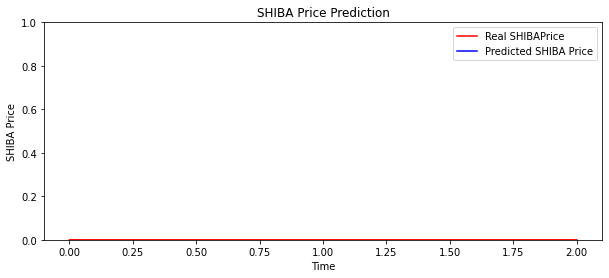

In [17]:
# Visualising the results
plt.figure(figsize=(10,4))
plt.plot(y_test[0:y_test.shape[0]-5], color = 'red', label = 'Real SHIBAPrice')
plt.plot(pred, color = 'blue', label = 'Predicted SHIBA Price')
plt.title('SHIBA Price Prediction')
plt.xlabel('Time')
plt.ylabel('SHIBA Price')
plt.ylim(0,1)
plt.legend()
plt.show()

In [18]:
# on cmd promt, you should use the function below to kill the tensorboard 
#taskkill /im tensorboard.exe /f
#del /q %TMP%\.tensorboard-info\*#

In [19]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2592), started 0:05:49 ago. (Use '!kill 2592' to kill it.)